In [19]:
import pandas as pd
import os

# Specify the data folder
data_folder = "./../original_data"

# Read each CSV file into a separate DataFrame
attendance_df = pd.read_csv(os.path.join(data_folder, 'attendance.csv'))
games_df = pd.read_csv(os.path.join(data_folder, 'games.csv'))
standings_df = pd.read_csv(os.path.join(data_folder, 'standings.csv'))

# Year filtering

In [20]:
attendance_df = attendance_df[(attendance_df['year'] >= 2010) & (attendance_df['year'] <= 2019)]
games_df = games_df[(games_df['year'] >= 2010) & (games_df['year'] <= 2019)]
standings_df = standings_df[(standings_df['year'] >= 2008) & (standings_df['year'] <= 2019)] # Here we allow two years before

# Homogeneous name

In [21]:
attendance_df["team_full_name"] = attendance_df["team"] + " " + attendance_df["team_name"]
#attendance_df = attendance_df.drop(columns=["team", "team_name"])

# Same on standings_df
standings_df["team_full_name"] = standings_df["team"] + " " + standings_df["team_name"]
standings_df = standings_df.drop(columns=["team", "team_name"])

# Drop this columns from scores_df 
games_df = games_df.drop(columns=["home_team_name", "away_team_name"])

# Drop useless cols

In [22]:
# attendance_df = attendance_df[["year", "team_full_name", "week", "weekly_attendance"]]# Resort columns

# Splitt regular season and other 

In [23]:
# We create a new df with this values called spetial games
special_games_df = games_df[games_df['week'].isin(['WildCard', 'Division', 'ConfChamp', 'SuperBowl'])].copy()

# We drop the special games from the original df
games_df = games_df[~games_df['week'].isin(['WildCard', 'Division', 'ConfChamp', 'SuperBowl'])].copy()

# Column types


In [24]:
# Specify column types for attendance_df
attendance_df[["year", "week", "weekly_attendance"]] = attendance_df[["year", "week", "weekly_attendance"]].astype("Int16", errors="ignore")
attendance_df["team_full_name"] = attendance_df["team_full_name"].astype("string")

# Specify column types for games_df
games_df[["year", "week", "pts_win", "pts_loss", "yds_win", "yds_loss", "turnovers_win", "turnovers_loss"]] = games_df[["year", "week", "pts_win", "pts_loss", "yds_win", "yds_loss", "turnovers_win", "turnovers_loss"]].astype("Int16", errors="ignore")
games_df[["home_team", "away_team", "home_team_city", "away_team_city"]] = games_df[["home_team", "away_team", "home_team_city", "away_team_city"]].astype("string")

# Specify column types for standings_df
standings_df[["year", "wins", "loss", "points_for", "points_against", "points_differential"]] = standings_df[["year", "wins", "loss", "points_for", "points_against", "points_differential"]].astype("Int16", errors="ignore")
standings_df[["margin_of_victory", "strength_of_schedule", "simple_rating", "offensive_ranking", "defensive_ranking"]] = standings_df[["margin_of_victory", "strength_of_schedule", "simple_rating", "offensive_ranking", "defensive_ranking"]].astype("float")
standings_df[["playoffs", "team_full_name", "sb_winner"]] = standings_df[["playoffs", "team_full_name", "sb_winner"]].astype("string")

# Specify column types for special_games_df
special_games_df[["year", "pts_win", "pts_loss", "yds_win", "yds_loss", "turnovers_win", "turnovers_loss"]] = special_games_df[["year", "pts_win", "pts_loss", "yds_win", "yds_loss", "turnovers_win", "turnovers_loss"]].astype("Int16", errors="ignore")
special_games_df[["week", "home_team", "away_team", "home_team_city"]] = special_games_df[["week", "home_team", "away_team", "home_team_city"]].astype("string")

# Create attendance as percentage

In [25]:
# Maximum of all seasons
attendance_df["weekly_attendance_ratio"] = attendance_df.groupby("team_full_name")["weekly_attendance"].transform(lambda x: x / x.max()) 

# Maximum for each season since they moved  the stadium
selected_teams_names = ["Chargers", "Rams"]
attendance_df_subset = attendance_df[attendance_df["team_name"].isin(selected_teams_names)].copy()
attendance_df_subset["weekly_attendance_ratio"] = attendance_df_subset.groupby(["team_full_name", "year"])["weekly_attendance"].transform(lambda x: x / x.max())

# Merging 
attendance_df.loc[attendance_df_subset.index, "weekly_attendance_ratio"] = attendance_df_subset["weekly_attendance_ratio"]

# Select relevant columns for attendance_df
attendance_df = attendance_df[["year", "team_full_name", "week", "weekly_attendance"]]# Resort columns

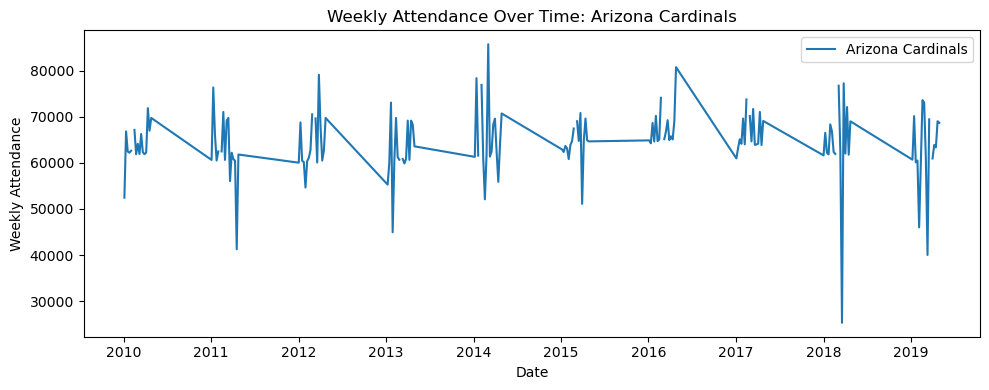

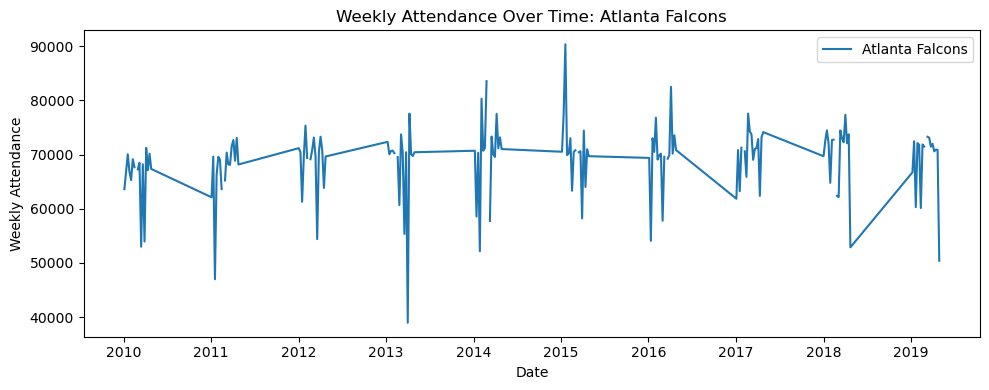

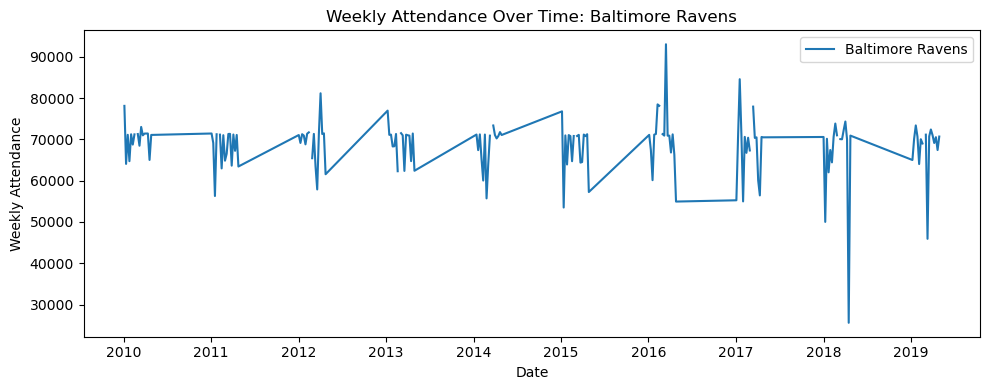

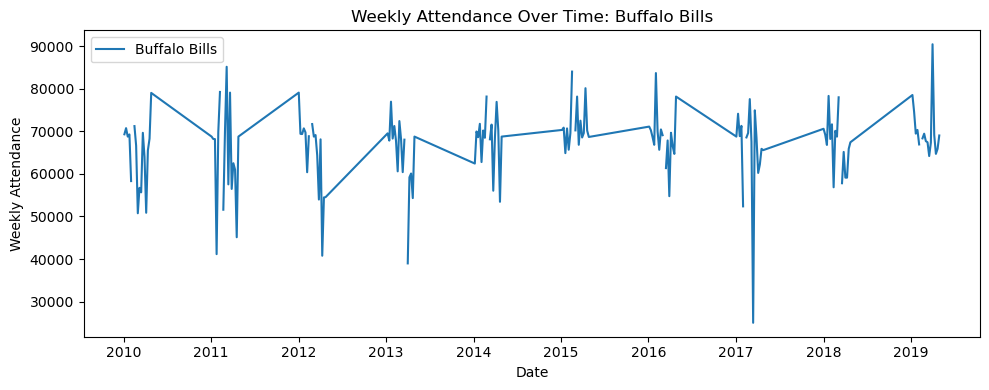

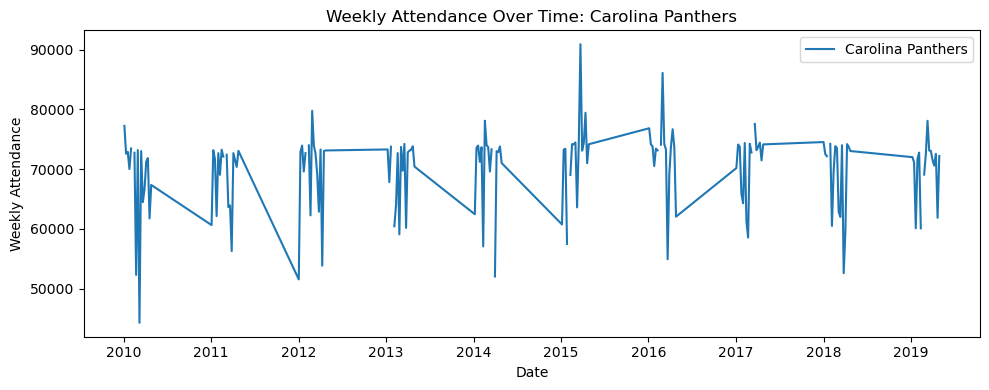

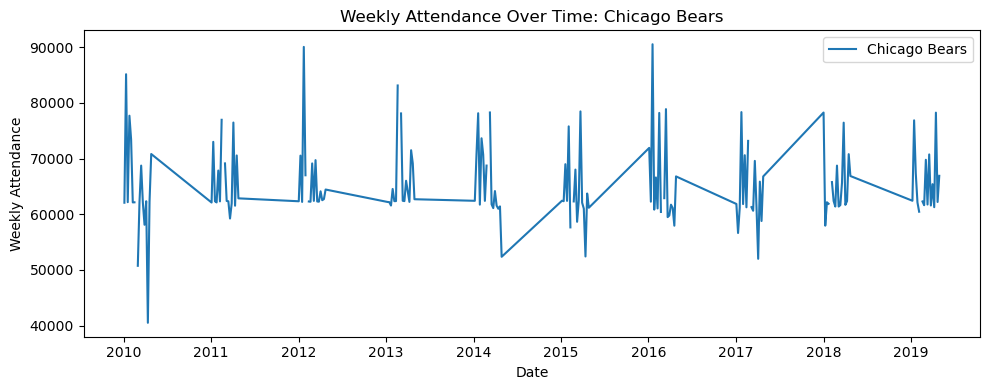

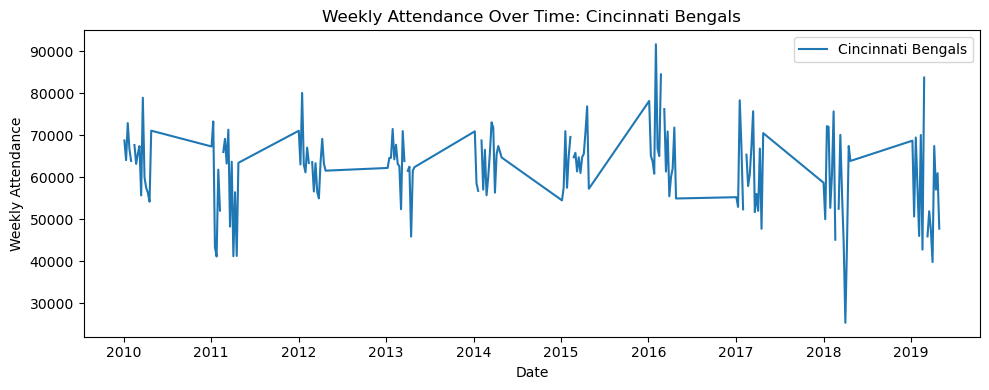

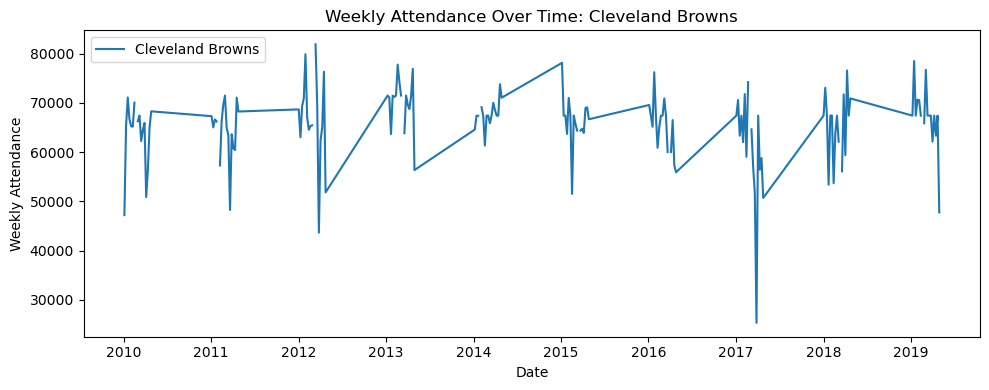

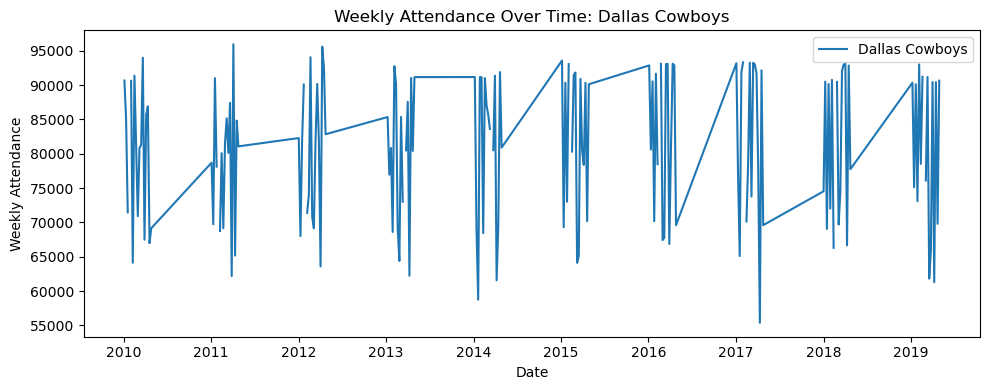

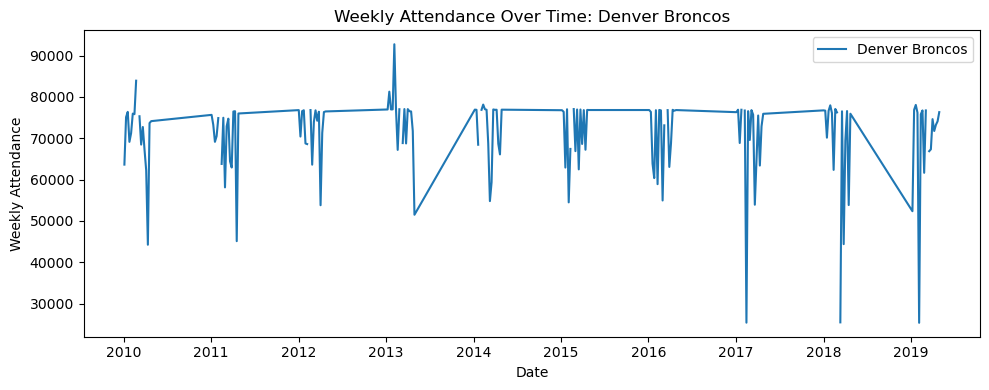

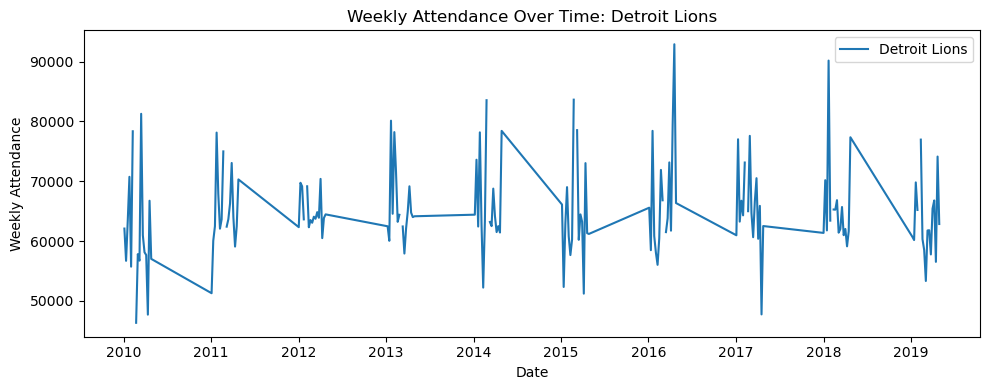

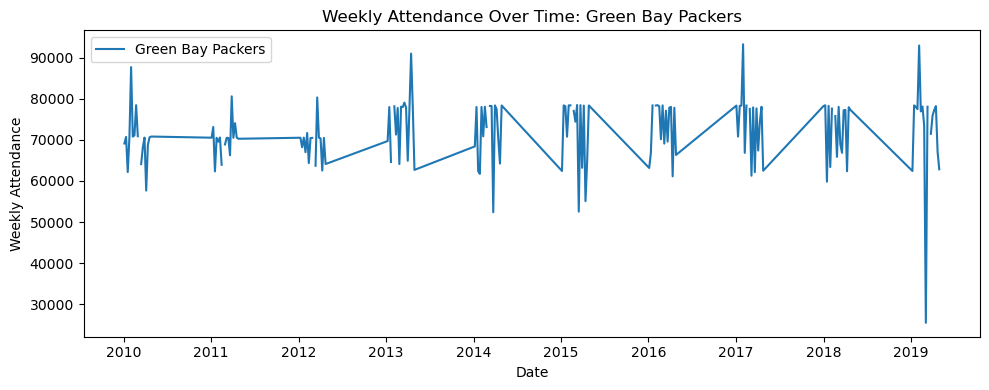

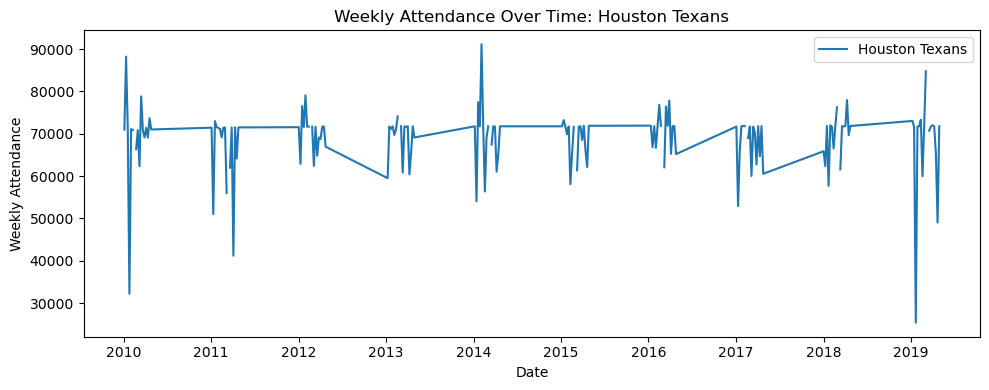

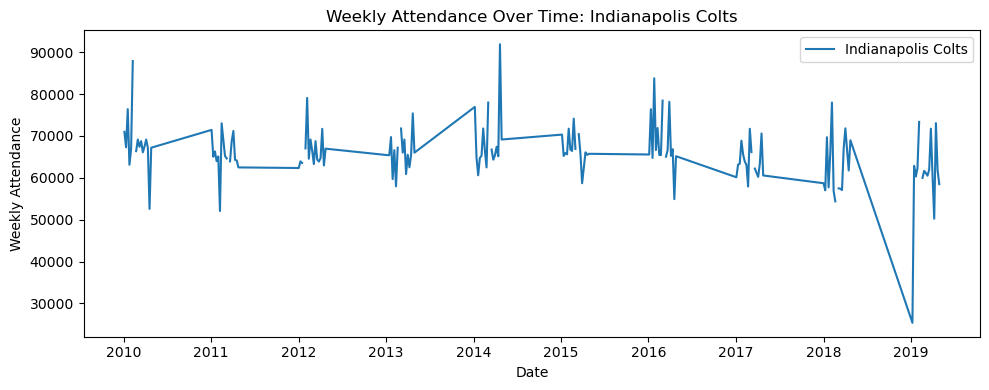

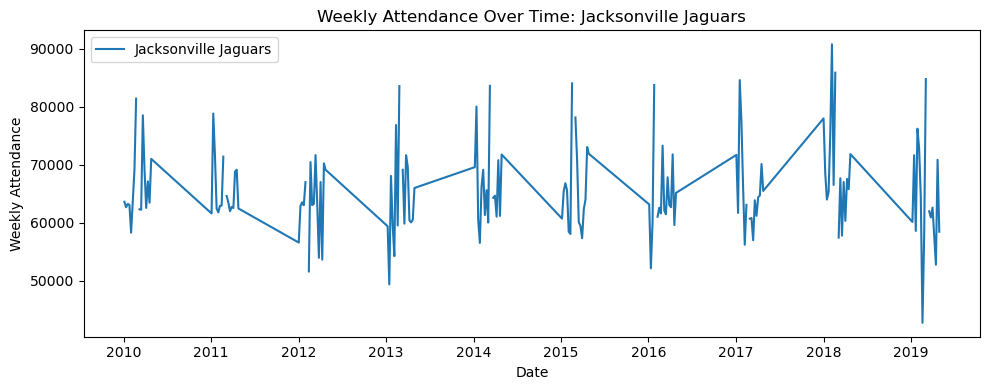

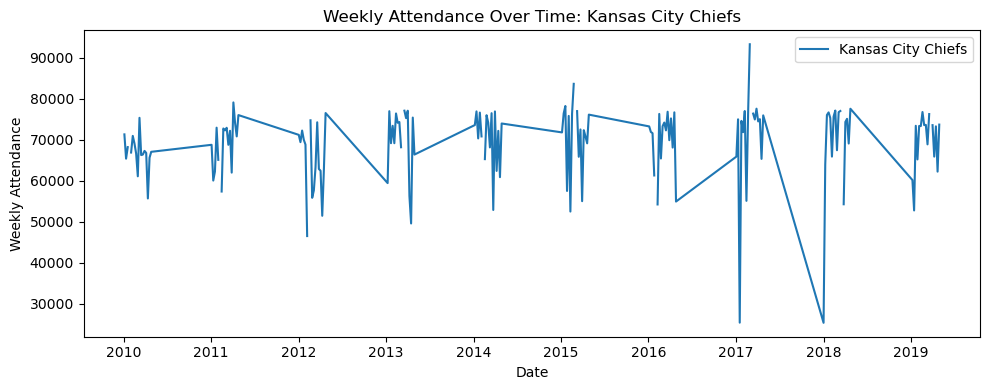

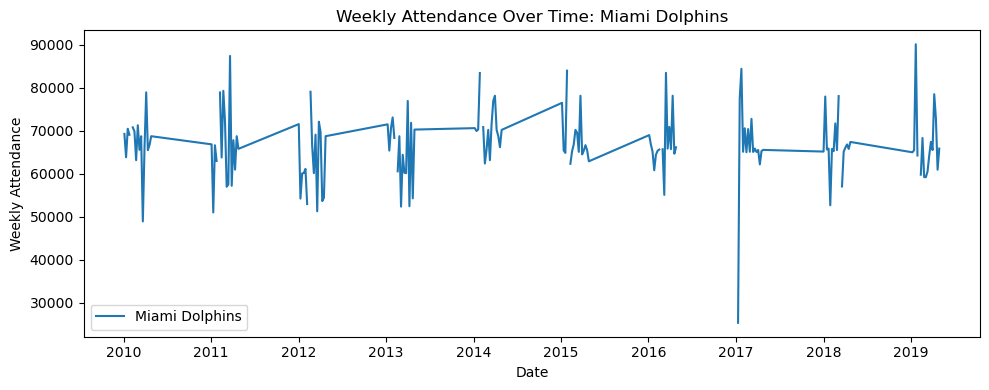

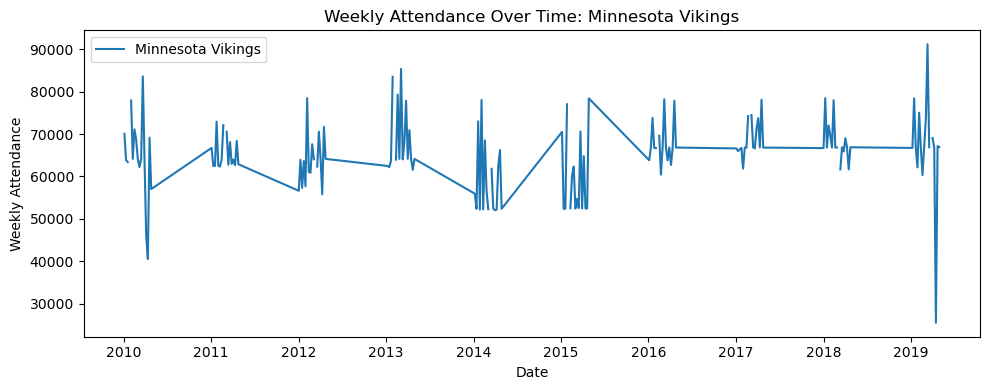

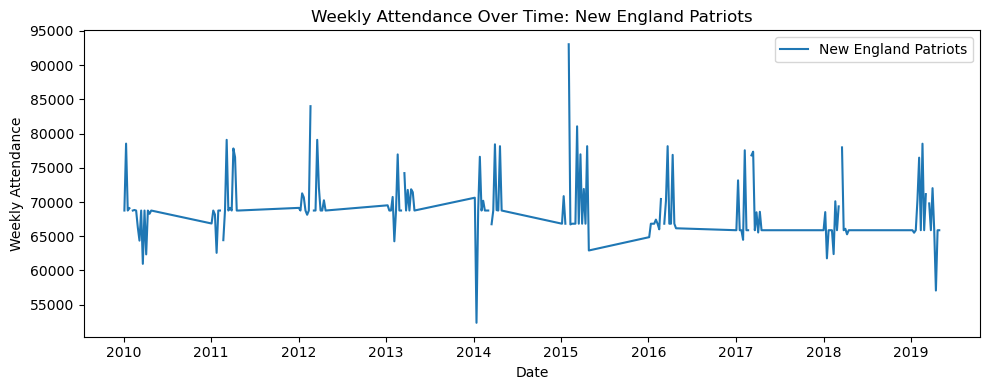

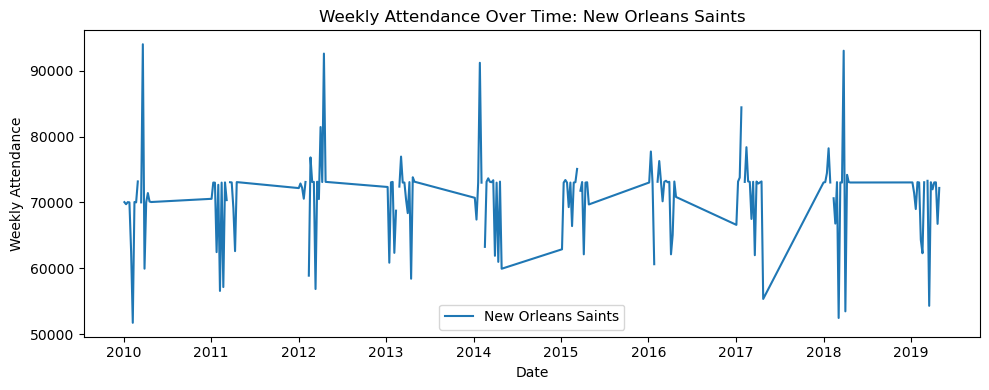

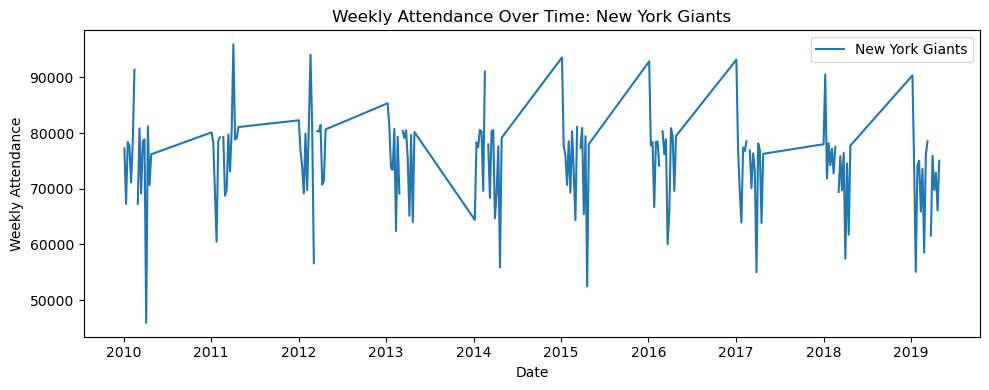

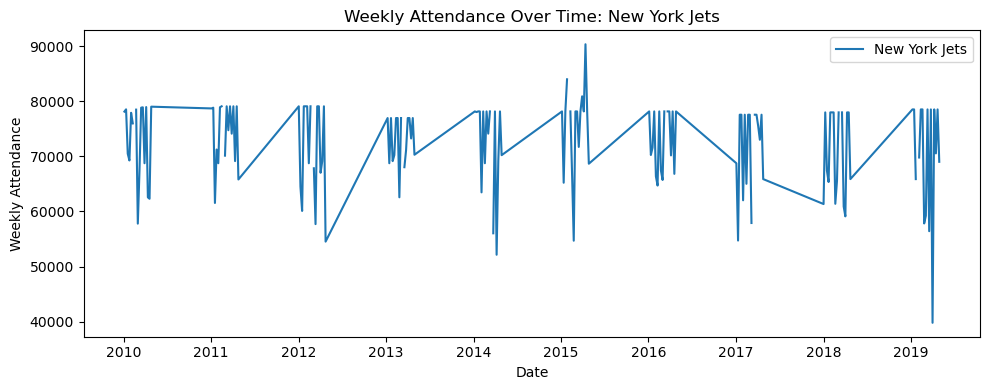

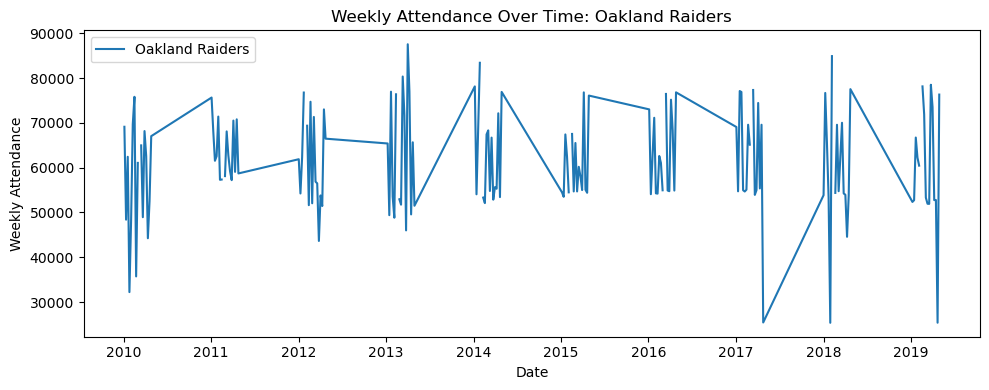

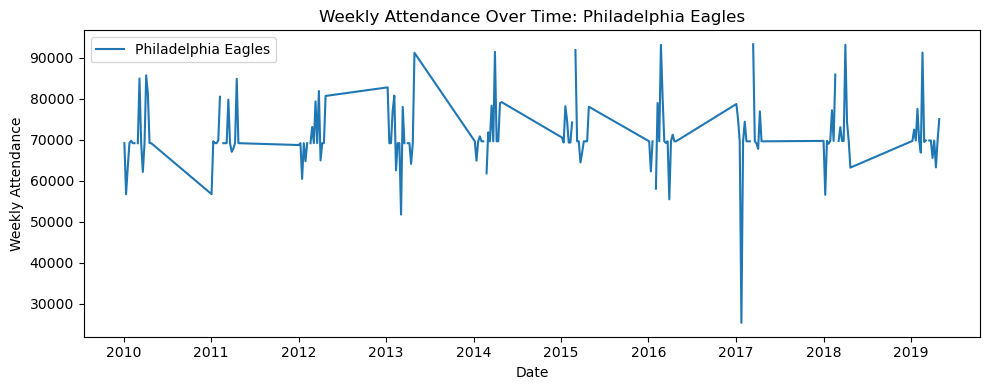

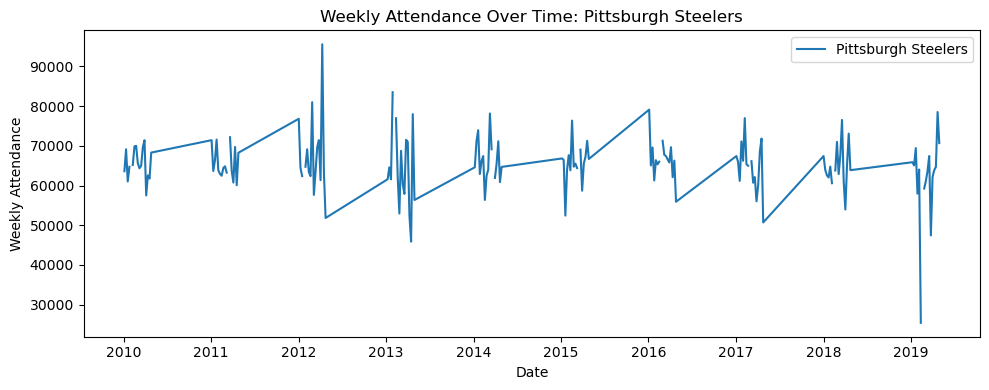

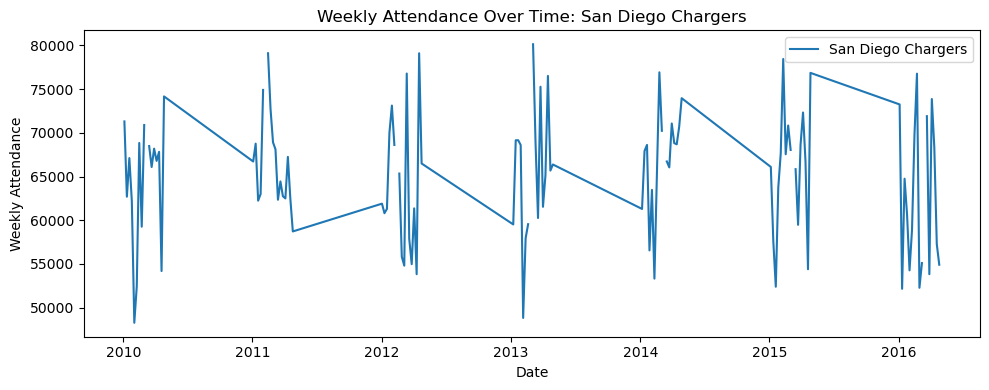

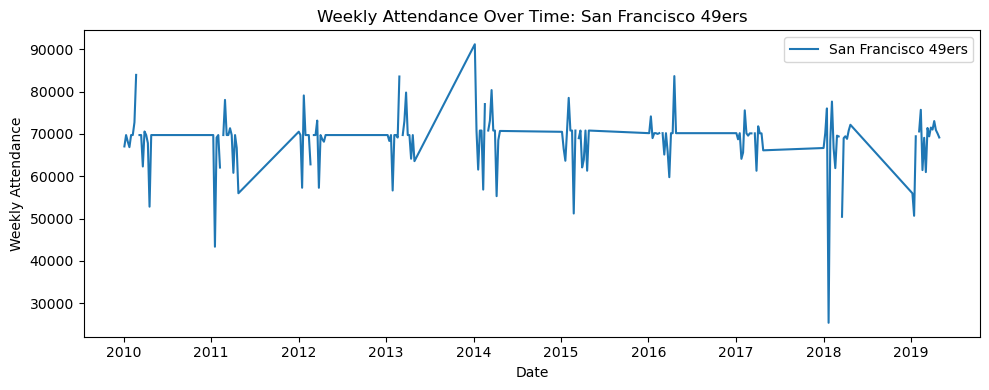

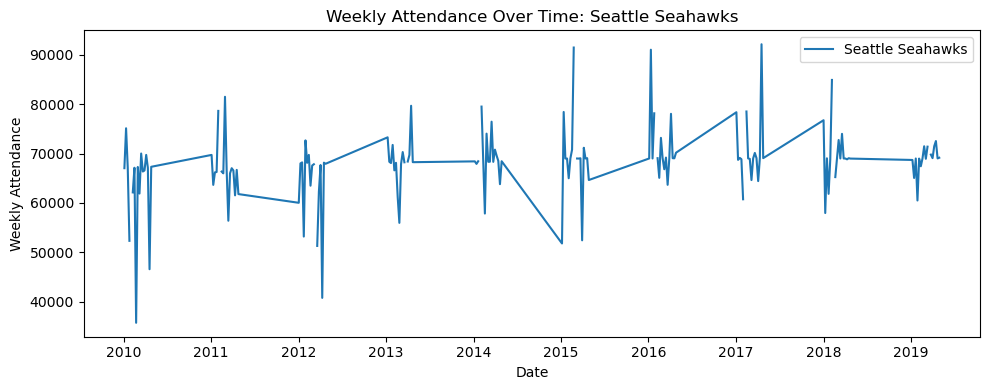

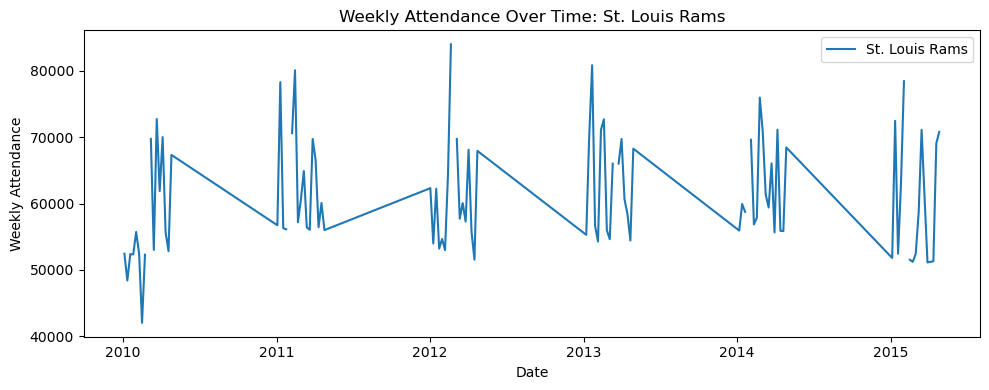

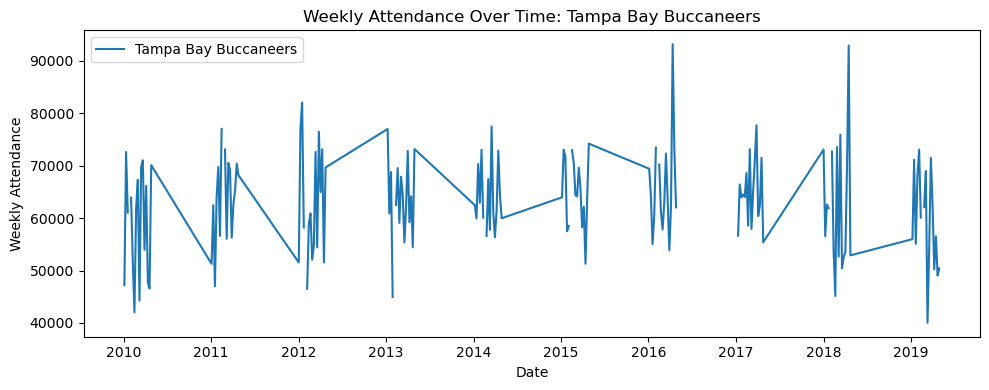

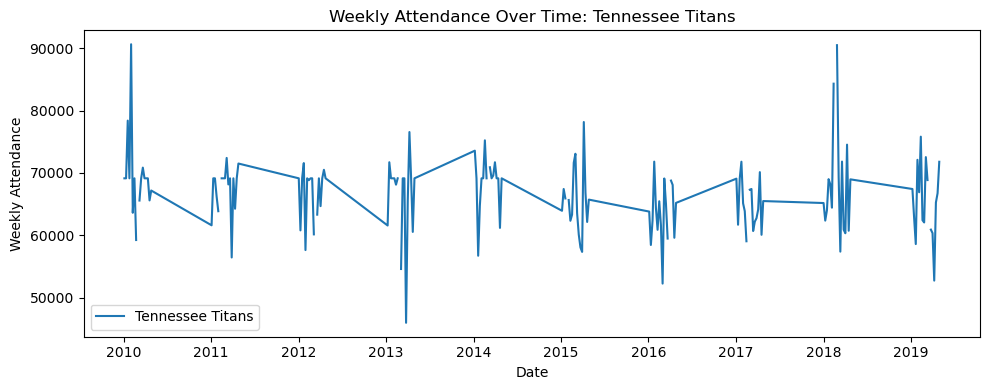

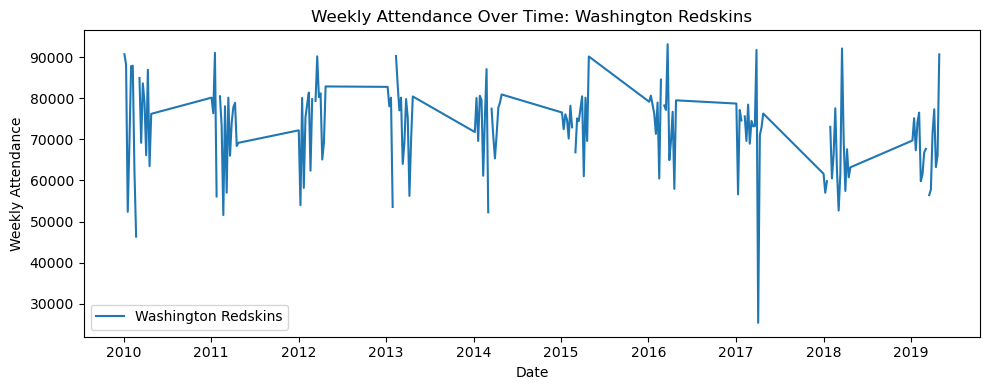

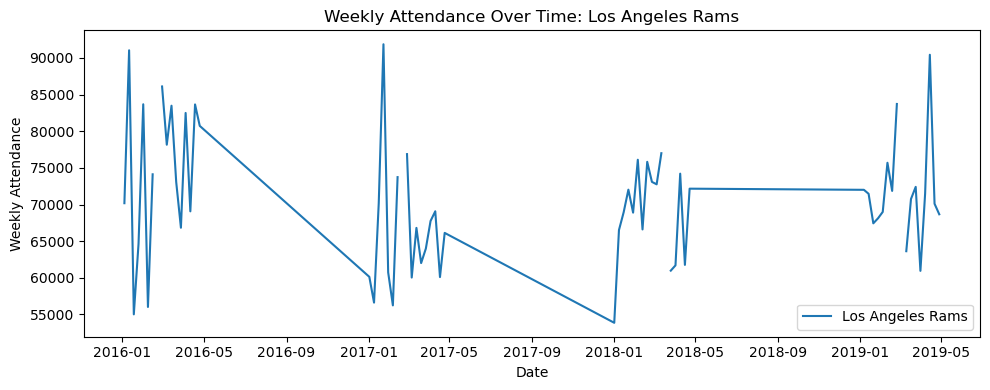

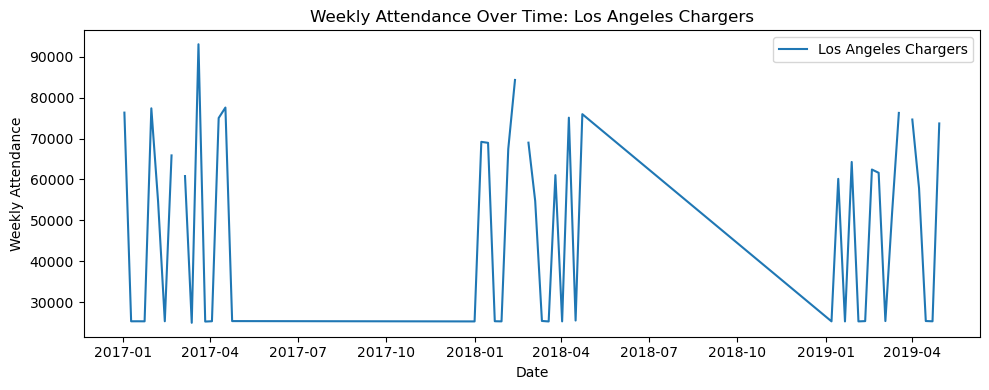

In [26]:
import matplotlib.pyplot as plt

teams_to_plot = attendance_df["team_full_name"].unique()

for team in teams_to_plot:
    team_data = attendance_df[attendance_df["team_full_name"] == team]
    plt.figure(figsize=(10, 4))
    plt.plot(
        pd.to_datetime(team_data["year"].astype(str) + "-W" + team_data["week"].astype(str) + "-1", format="%Y-W%W-%w"),
        team_data["weekly_attendance"],
        label=team
    )
    plt.xlabel("Date")
    plt.ylabel("Weekly Attendance")
    plt.title(f"Weekly Attendance Over Time: {team}")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Merge attendance to games 

In [27]:
games_df = pd.merge(
    games_df,
    attendance_df,
    left_on=['home_team', 'year', 'week'],
    right_on=['team_full_name', 'year', 'week'],
    how='inner'
).drop(columns=['team_full_name']).sort_values(by=['year', 'week', 'time'])

# Last year performance

In [28]:
prev_year_winners = standings_df[standings_df['sb_winner'] == 'Won Superbowl'][["year", "team_full_name"]].copy()
prev_year_winners["year"] += 1  # Shift the year forward so we can match it to the next season

# Merge it with games_df on year and home_team
games_df = games_df.merge(
    prev_year_winners,
    how="left",
    left_on=["year", "home_team"],
    right_on=["year", "team_full_name"]
)

# If the merge was successful, it means the home team was the previous year's Super Bowl winner
games_df["home_team_superbowl_winner_last_season"] = games_df["team_full_name"].notna()

# Drop the extra columns from the merge
games_df = games_df.drop(columns="team_full_name")

# Check if the away team is the previous year's Super Bowl winner
games_df = games_df.merge(
    prev_year_winners,
    how="left",
    left_on=["year", "away_team"],
    right_on=["year", "team_full_name"]
)

# If the merge was successful, it means the away team was the previous year's Super Bowl winner
games_df["away_team_superbowl_winner_last_season"] = games_df["team_full_name"].notna()

games_df = games_df.drop(columns="team_full_name")

In [29]:
# Filter teams that made the playoffs (but not necessarily won the Super Bowl)
playoffs_finishers = standings_df[standings_df['playoffs'] == 'Playoffs'][["year", "team_full_name"]].copy()
playoffs_finishers["year"] += 1  # Shift to next season for matching

# Super Bowl winner
prev_year_winners = standings_df[standings_df['sb_winner'] == 'Won Superbowl'][["year", "team_full_name"]].copy()
prev_year_winners["year"] += 1

# Merge for home team: Super Bowl winner
games_df = games_df.merge(
    prev_year_winners,
    how="left",
    left_on=["year", "home_team"],
    right_on=["year", "team_full_name"]
)
games_df["home_team_superbowl_winner_last_season"] = games_df["team_full_name"].notna()
games_df = games_df.drop(columns="team_full_name")

# Merge for away team: Super Bowl winner
games_df = games_df.merge(
    prev_year_winners,
    how="left",
    left_on=["year", "away_team"],
    right_on=["year", "team_full_name"]
)
games_df["away_team_superbowl_winner_last_season"] = games_df["team_full_name"].notna()
games_df = games_df.drop(columns="team_full_name")

# Merge for home team: Playoff participant
games_df = games_df.merge(
    playoffs_finishers,
    how="left",
    left_on=["year", "home_team"],
    right_on=["year", "team_full_name"]
)
games_df["home_team_playoffs_last_season"] = games_df["team_full_name"].notna()
games_df = games_df.drop(columns="team_full_name")

# Merge for away team: Playoff participant
games_df = games_df.merge(
    playoffs_finishers,
    how="left",
    left_on=["year", "away_team"],
    right_on=["year", "team_full_name"]
)
games_df["away_team_playoffs_last_season"] = games_df["team_full_name"].notna()
games_df = games_df.drop(columns="team_full_name")

In [30]:
# Ensure the data is sorted chronologically for correct rolling computation
games_df = games_df.sort_values(by=["year", "week"]).reset_index(drop=True)

# Create helper columns for win flags
games_df["home_win"] = (games_df["winner"] == games_df["home_team"]).astype(int)
games_df["away_win"] = (games_df["winner"] == games_df["away_team"]).astype(int)

# Build a long format DataFrame with one row per team per game
home_games = games_df[["year", "week", "home_team", "home_win"]].copy()
home_games.columns = ["year", "week", "team", "win"]

away_games = games_df[["year", "week", "away_team", "away_win"]].copy()
away_games.columns = ["year", "week", "team", "win"]

team_games = pd.concat([home_games, away_games]).sort_values(by=["team", "year", "week"]).reset_index(drop=True)

# Compute rolling win count over the last 3 games for each team
team_games["rolling_win_count_3wk"] = (
    team_games.groupby("team")["win"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).sum().shift(1))  # shift(1) to exclude current week
)

# Merge back into main DataFrame for home and away teams
# Home
home_rolling = team_games[["year", "week", "team", "rolling_win_count_3wk"]].copy()
home_rolling.columns = ["year", "week", "home_team", "home_team_wins_last_3"]

games_df = games_df.merge(home_rolling, on=["year", "week", "home_team"], how="left")

# Away
away_rolling = team_games[["year", "week", "team", "rolling_win_count_3wk"]].copy()
away_rolling.columns = ["year", "week", "away_team", "away_team_wins_last_3"]

games_df = games_df.merge(away_rolling, on=["year", "week", "away_team"], how="left")

games_df

,year,week,home_team,away_team,winner,tie,day,date,time,pts_win,...,away_team_city,weekly_attendance,home_team_superbowl_winner_last_season,away_team_superbowl_winner_last_season,home_team_playoffs_last_season,away_team_playoffs_last_season,home_win,away_win,home_team_wins_last_3,away_team_wins_last_3
0,2010,1,Kansas City Chiefs,San Diego Chargers,Kansas City Chiefs,NaN,Mon,September 13,10:20PM,21,...,San Diego,71297.0,False,False,False,True,1,0,NaN,NaN
1,2010,1,Pittsburgh Steelers,Atlanta Falcons,Pittsburgh Steelers,NaN,Sun,September 12,1:02PM,15,...,Atlanta,63609.0,False,False,False,False,1,0,NaN,NaN
2,2010,1,Chicago Bears,Detroit Lions,Chicago Bears,NaN,Sun,September 12,1:02PM,19,...,Detroit,62080.0,False,False,False,False,1,0,NaN,NaN
3,2010,1,Tampa Bay Buccaneers,Cleveland Browns,Tampa Bay Buccaneers,NaN,Sun,September 12,1:02PM,17,...,Cleveland,47211.0,False,False,False,False,1,0,NaN,NaN
4,2010,1,Houston Texans,Indianapolis Colts,Houston Texans,NaN,Sun,September 12,1:02PM,34,...,Indianapolis,70974.0,False,False,False,True,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2019,17,New York Giants,Philadelphia Eagles,Philadelphia Eagles,NaN,Sun,December 29,4:25PM,34,...,Philadelphia,75029.0,False,False,False,True,0,1,2.0,3.0
2556,2019,17,Dallas Cowboys,Washington Redskins,Dallas Cowboys,NaN,Sun,December 29,4:25PM,47,...,Washington,90646.0,False,False,True,False,1,0,1.0,0.0
2557,2019,17,Baltimore Ravens,Pittsburgh Steelers,Baltimore Ravens,NaN,Sun,December 29,4:25PM,28,...,Pittsburgh,70695.0,False,False,True,False,1,0,3.0,1.0
2558,2019,17,Los Angeles Rams,Arizona Cardinals,Los Angeles Rams,NaN,Sun,December 29,4:25PM,31,...,Arizona,68665.0,False,False,True,False,1,0,1.0,2.0


In [31]:
# Save games_df to the process folder as a CSV file
process_folder = "./../processed_data"
os.makedirs(process_folder, exist_ok=True)
games_df.to_csv(os.path.join(process_folder, "games.csv"), index=False)

# Merging weather data (New York Giants)

In [37]:
team_name = 'New York Giants'
nickname = team_name.split(' ')[-1].lower()


weather_data_path = './../weather_data'
weather_df = pd.read_csv(weather_data_path+'/export_'+nickname+'.csv')

games_df['full_date'] = pd.to_datetime(games_df['date'] + ' ' + games_df['year'].astype(str), format='%B %d %Y')

df_pats = games_df.loc[games_df['home_team'] == team_name]

weather_df.rename(columns={'date': 'full_date'}, inplace=True)
weather_df['full_date'] = pd.to_datetime(weather_df['full_date'])

df_pats = df_pats.merge(weather_df, on=['full_date'], how='left')

process_folder = "./../datasets_w_weather_data"
os.makedirs(process_folder, exist_ok=True)
df_pats.to_csv(os.path.join(process_folder, f"{team_name}.csv"), index=False)